# Data Science Challenge

In [1]:
# If you'd like to install packages that are not installed by default, uncomment the last two lines of this cell and replace <package list> with a list of your packages.
# This will ensure your notebook has all the dependencies and works everywhere

#import sys
#!{sys.executable} -m pip install <package list>

In [2]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn import linear_model
import re 
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from lofo import LOFOImportance, Dataset, plot_importance
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn import svm
import warnings
# warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option("display.max_columns", 101)

/usr/local/lib/python3.9/site-packages/lofo/lofo_importance.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Data Description

Column | Description
:---|:---
`id` | Unique identifier of a bank
`institution_name` | Name of the bank
`institution_type` | Type of bank with respect to its operation (savings bank, savings association or commercial bank)
`charter_type` | Type of bank defined with respect to its area of operation (STATE, FEDERAL, STATE/FEDERAL)
`headquarters` | Location of the bank's headquarters in the US (City, State)
`latitude` | Latitude of the bank's State
`longitude` | Longitude of the bank's State
`failure_date` | Date on which the bank was officially declared as a failure
`insurance_provider` | Insurance provider to the bank depositors (FDIC, FSLIC, RTC, BIF, SAIF, DIF)
`failure_outcome` | Bailout plan for the bank after failure (PAYOUT, ACQUISITION, PRIVATIZATION, TRANSFER, MANAGEMENT CHANGE)
`total_deposits` | Total deposits in the bank at the time of failure (in thousands of dollars)
`total_assets` | Total assets in the bank at the time of failure (in thousands of dollars)
`liquidity` | Percentage of total available liquid assets at the time of failure
`estimated_loss` | Net Expected Loss (in thousands $)

## Data Wrangling & Visualization

### Load and Analyze Training Data

In [3]:
# Dataset is already loaded below
data = pd.read_csv("train.csv")

# Dimensions of data
data.shape

(2612, 14)

In [4]:
# Explore columns
data.columns

Index(['id', 'institution_name', 'institution_type', 'charter_type',
       'headquarters', 'latitude', 'longitude', 'failure_date',
       'insurance_provider', 'failure_outcome', 'total_deposits',
       'total_assets', 'liquidity', 'estimated_loss'],
      dtype='object')

In [5]:
# Description
data.describe()

,id,latitude,longitude,total_deposits,total_assets,liquidity,estimated_loss
count,2612.000000,2612.000000,2612.000000,2370.000000,2456.000000,2491.000000,2612.000000
mean,1306.500000,36.605476,-93.282244,249.681728,295.408871,0.944116,60.300897
std,754.163775,6.338471,15.556196,899.145692,1222.587473,0.227829,314.047100
min,1.000000,-34.000000,-157.855676,0.005000,0.014000,0.068777,0.001000
25%,653.750000,32.470970,-98.434186,14.244750,14.418000,0.878566,2.380235
50%,1306.500000,36.130369,-94.788141,45.151500,46.186000,0.947690,8.862500
75%,1959.250000,40.916765,-84.898761,162.168750,170.097250,0.994023,35.115500
max,2612.000000,69.750000,147.164340,20072.099000,30698.512000,8.897978,12438.005000


In [6]:
data.head()

,id,institution_name,institution_type,charter_type,headquarters,latitude,longitude,failure_date,insurance_provider,failure_outcome,total_deposits,total_assets,liquidity,estimated_loss
0,1,AMERICAN DIVERSIFIED SAVINGS BANK,SAVINGS ASSOCIATION,FEDERAL/STATE,"COSTA MESA, CA",33.663339,-117.903317,1986-02-14,FSLIC,PAYOUT,958.953,978.635,0.979888,472.36480
1,2,COMMUNITYSOUTH BANK AND TRUST,COMMERCIAL BANK,STATE,"EASLEY, SC",34.826928,-82.581705,2011-01-21,DIF,ACQUISITION,314.250,340.986,0.921592,51.33000
2,3,WATSON STATE BANK,COMMERCIAL BANK,STATE,"WATSON, MN",45.009723,-95.801348,1988-09-30,FDIC,ACQUISITION,12.865,NaN,0.936931,5.10400
3,4,FIRST AMERICA FSB,SAVINGS BANK,STATE,"LONGMONT, CO",40.167212,-105.101929,1990-03-16,RTC,PAYOUT,146.818,187.366,0.783589,41.29300
4,5,BANK OF HUNTER,COMMERCIAL BANK,STATE,"HUNTER, OK",36.563643,-97.661163,1985-04-04,FDIC,ACQUISITION,3.109,3.001,1.035988,1.19114


In [7]:
# Check total missing vals in every column
data.isnull().sum()

id                      0
institution_name        0
institution_type        0
charter_type            0
headquarters            0
latitude                0
longitude               0
failure_date            0
insurance_provider      0
failure_outcome         0
total_deposits        242
total_assets          156
liquidity             121
estimated_loss          0
dtype: int64

<AxesSubplot:>

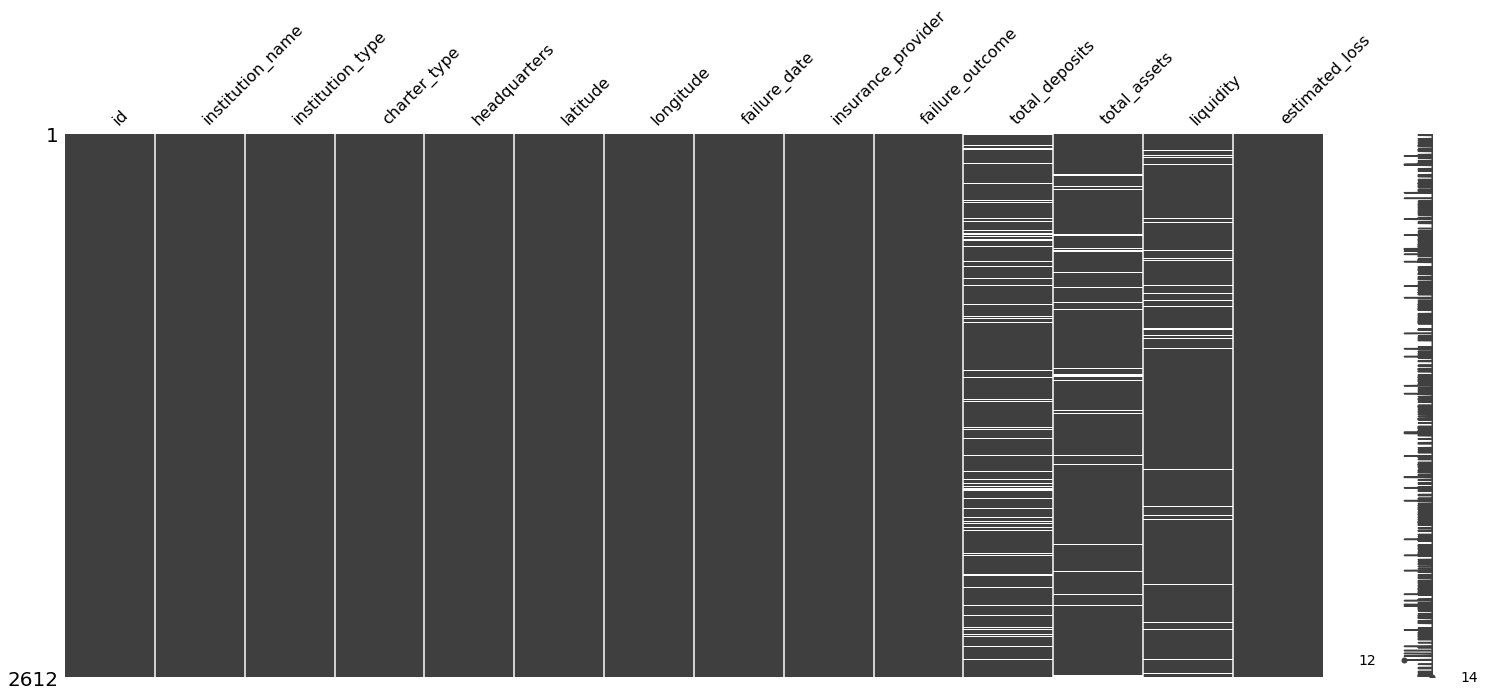

In [8]:
# plot missing values
%matplotlib inline
msno.matrix(data)

### Feature Encoding of Features in Training Data

In [9]:
# create a copy of data
train_data = data.copy()

In [10]:
train_data.dtypes

id                      int64
institution_name       object
institution_type       object
charter_type           object
headquarters           object
latitude              float64
longitude             float64
failure_date           object
insurance_provider     object
failure_outcome        object
total_deposits        float64
total_assets          float64
liquidity             float64
estimated_loss        float64
dtype: object

In [11]:
# get most frequently occuring value in headquarters column
train_data['headquarters'].mode()

0    HOUSTON, TX
dtype: object

In [12]:
# the name of institution is not important in figuring out estimated loss so I'll remove it. 
# also we have latitude and longitude of the bank's headquarters so we don't need the headquarters variable
train_data.drop(columns=['institution_name', 'headquarters'], inplace=True)

In [13]:
# also convert failure date object date time and just keep the year value
train_data['failure_date'] = pd.to_datetime(train_data['failure_date'])
train_data['failure_date'] = train_data['failure_date'].dt.year

In [14]:
# one-hot encoding of categorical features
cat_cols = ['institution_type', 'charter_type', 'insurance_provider', 'failure_outcome']
data_encoding = {}
frames = []
for col in cat_cols:
    print(col)
    lb = LabelBinarizer()
    data_encoding[col] = lb
    result = lb.fit_transform(train_data[col].values.tolist())
    dfOneHot = pd.DataFrame(result, columns = [col + '_' + c for c in lb.classes_])
    frames.append(dfOneHot)

institution_type
charter_type
insurance_provider
failure_outcome


In [15]:
# concatenate all dataframes
final_data = pd.concat(frames, axis=1)
final_data.shape

(2612, 17)

In [16]:
# drop remaining cols in train_data
train_data = train_data.drop(columns=cat_cols)

In [17]:
# adding remaining cols
for c in train_data.columns:
    final_data[c] = train_data[c].values
print(final_data.shape)
print(final_data.isnull().values.any())

(2612, 25)
True


### Impute Missing Values in Training Data

In [18]:
# list of columns with NAN values
miss_cols = [c for c in final_data.columns if final_data[c].isnull().sum() > 0]
miss_cols

['total_deposits', 'total_assets', 'liquidity']

In [19]:
# impute missing values in total_assets and liquidity with median values
final_data.loc[final_data['total_assets'].isna(), 'total_assets'] = final_data['total_assets'].median()
final_data.loc[final_data['liquidity'].isna(), 'liquidity'] = final_data['liquidity'].median()

In [20]:
remain_cols = [c for c in miss_cols if final_data[c].isnull().sum() > 0]
remain_cols

['total_deposits']

In [21]:
# impute missing values in this column with Regression
for c in remain_cols:
    observed = final_data[final_data[c].notnull()]
    missing = final_data[final_data[c].isnull()]
    y, X = observed[c], observed.drop(columns=remain_cols)
    model = RandomForestRegressor()
    model.fit(X, y)
    final_data.loc[final_data[c].isnull(), c] = model.predict(missing.drop(columns=remain_cols))

In [22]:
# check if there is any missing value or not
final_data.isnull().values.any()

False

### Load and Analyze Test Data

In [23]:
# Loading Test data
test_data = pd.read_csv('test.csv')
test_data.shape

(356, 13)

In [24]:
test_data.head()

,id,institution_name,institution_type,charter_type,headquarters,latitude,longitude,failure_date,insurance_provider,failure_outcome,total_deposits,total_assets,liquidity
0,1,HOHENWALD NATIONAL BANK,COMMERCIAL BANK,STATE,"HOHENWALD, TN",35.547851,-87.551963,1982-09-03,FDIC,PAYOUT,24.334,27.053,0.899494
1,2,ROSEMOUNT NATIONAL BANK,COMMERCIAL BANK,FEDERAL,"ROSEMOUNT, MN",44.739187,-93.126110,2011-04-15,DIF,ACQUISITION,20.980,21.454,0.977906
2,3,CITIZENS BANK OF GLENDALE,COMMERCIAL BANK,STATE,"DENVER, CO",39.739236,-104.984862,1987-08-27,FDIC,ACQUISITION,4.036,4.384,0.920620
3,4,THE STERLINGTON BANK,COMMERCIAL BANK,STATE,"STERLINGTON, LA",32.694432,-92.076030,1989-07-13,FDIC,ACQUISITION,14.646,15.243,0.960834
4,5,PEOPLES S & L ASSOC.,SAVINGS ASSOCIATION,FEDERAL/STATE,"HAMPTON, VA",37.052031,-76.285636,1989-06-29,RTC,ACQUISITION,24.322,23.943,1.015829


In [25]:
test_data.isnull().sum()

id                     0
institution_name       0
institution_type       0
charter_type           0
headquarters           0
latitude               0
longitude              0
failure_date           0
insurance_provider     0
failure_outcome        0
total_deposits         0
total_assets           0
liquidity             17
dtype: int64

### Encode Features in Test Data

In [26]:
# the name of institution is not important in figuring out estimated loss so I'll remove it
test_data.drop(columns=['institution_name', 'headquarters'], inplace=True)

In [27]:
# also convert failure date object date time and just keep the year value
test_data['failure_date'] = pd.to_datetime(test_data['failure_date'])
test_data['failure_date'] = test_data['failure_date'].dt.year

In [28]:
# perform one-hot encoding for test data
test_frames = []
for col in cat_cols:
    print(col)
    lb = data_encoding[col]
    result = lb.transform(test_data[col].values.tolist())
    dfOneHot = pd.DataFrame(result, columns = [col + '_' + c for c in lb.classes_])
    test_frames.append(dfOneHot)

institution_type
charter_type
insurance_provider
failure_outcome


In [29]:
# remove feature that were one-hot encoded
test_data = test_data.drop(columns=cat_cols)

In [30]:
# concatenate all dataframes
encoded_test_data = pd.concat(test_frames, axis=1)
encoded_test_data.shape

(356, 17)

In [31]:
# adding remaining cols
for c in test_data.columns:
    encoded_test_data[c] = test_data[c].values
print(encoded_test_data.dtypes)
print(encoded_test_data.shape)
print(encoded_test_data.isnull().values.any())

institution_type_COMMERCIAL BANK          int64
institution_type_SAVINGS ASSOCIATION      int64
institution_type_SAVINGS BANK             int64
charter_type_FEDERAL                      int64
charter_type_FEDERAL/STATE                int64
charter_type_STATE                        int64
insurance_provider_BIF                    int64
insurance_provider_DIF                    int64
insurance_provider_FDIC                   int64
insurance_provider_FSLIC                  int64
insurance_provider_RTC                    int64
insurance_provider_SAIF                   int64
failure_outcome_ACQUISITION               int64
failure_outcome_MANAGEMENT CHANGE         int64
failure_outcome_PAYOUT                    int64
failure_outcome_PRIVATIZATION             int64
failure_outcome_TRANSFER                  int64
id                                        int64
latitude                                float64
longitude                               float64
failure_date                            

### Impute Missing Values in Test Data

In [32]:
# impute missing values in total_assets and liquidity with median values
encoded_test_data.loc[encoded_test_data['total_assets'].isna(), 'total_assets'] = encoded_test_data['total_assets'].median()
encoded_test_data.loc[encoded_test_data['liquidity'].isna(), 'liquidity'] = encoded_test_data['liquidity'].median()

In [33]:
# # impute missing values in these columns with Regression
# for c in remain_cols:
#     observed = encoded_test_data[encoded_test_data[c].notnull()]
#     missing = encoded_test_data[encoded_test_data[c].isnull()]
#     y, X = observed[c], observed.drop(columns=remain_cols)
#     model = RandomForestRegressor()
#     model.fit(X, y)
#     encoded_test_data.loc[encoded_test_data[c].isnull(), c] = model.predict(missing.drop(columns=remain_cols))

In [34]:
# plot missing values
encoded_test_data.isnull().values.any()

False

## Visualization, Modeling, Machine Learning

Build a model that can predict whether patient opted for the procedure or not and identify how different features influence the model's decision. Please explain the findings effectively to technical and non-technical audiences using comments and visualizations, if appropriate.
- **Build an optimized model that effectively solves the business problem.**
- **The model will be evaluated on the basis of mean absolute error.**
- **Read the test.csv file and prepare features for testing.**

In [35]:
df_num = data.select_dtypes(include = ['float64', 'int64'])
df_num = df_num.drop(columns=['id'])
num_cols = df_num.columns.tolist()
num_cols

['latitude',
 'longitude',
 'total_deposits',
 'total_assets',
 'liquidity',
 'estimated_loss']

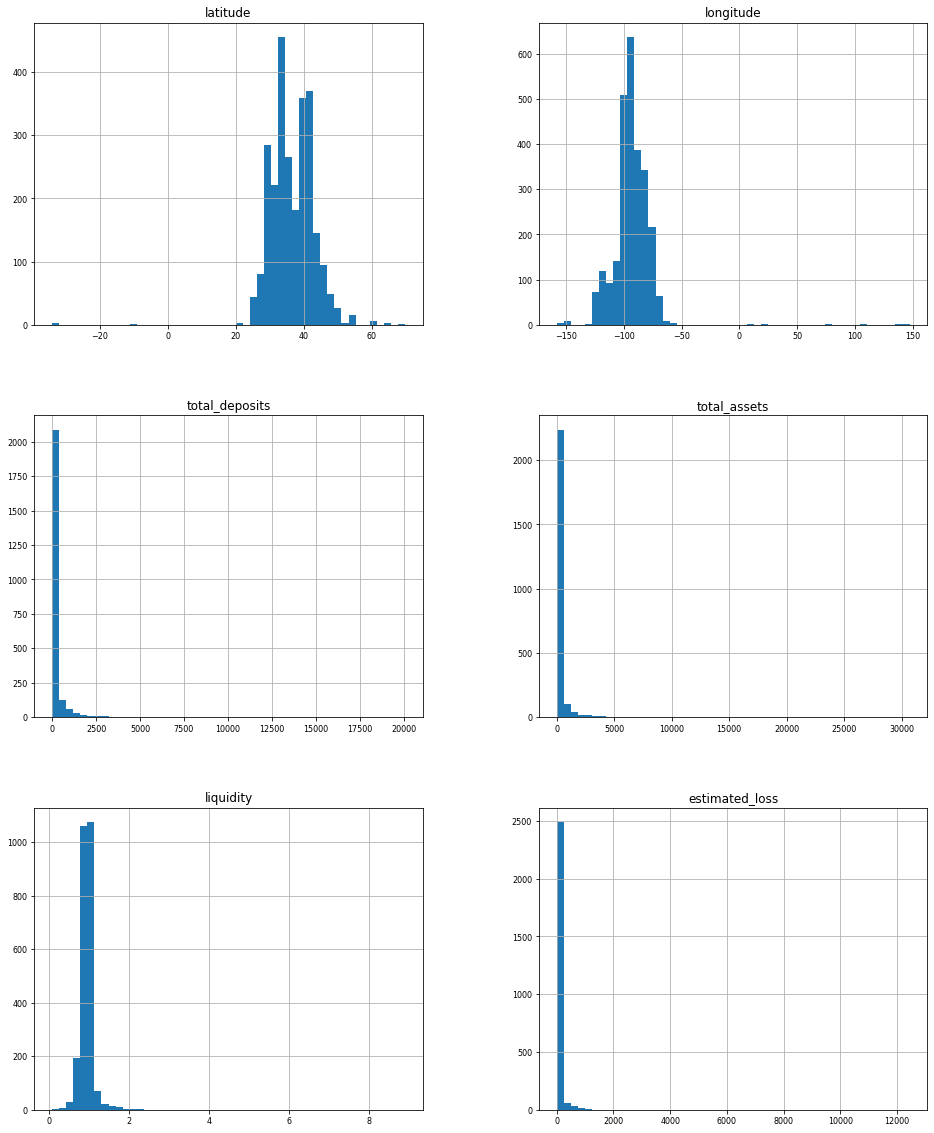

In [36]:
# histogram plots for continuous variables 
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

##### Most estimated_loss values lies in the range of 1 to 1000 k dollars, except a few outlier. Liquidity has kind of a normal distrubition ranging from 0 to 2. Whereas total_assets and total_deposits lie in range of 1 to 5000 k range. As for location, the most frequently occuring headquarters value is HOUSTON, TX (obtained in the start).

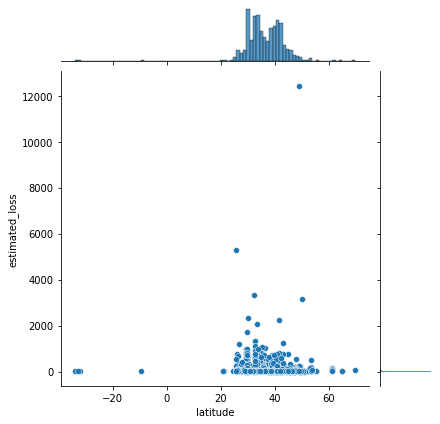

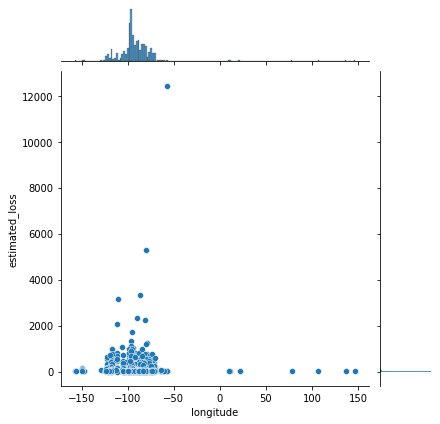

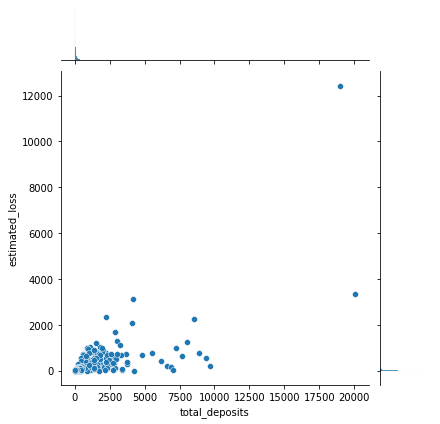

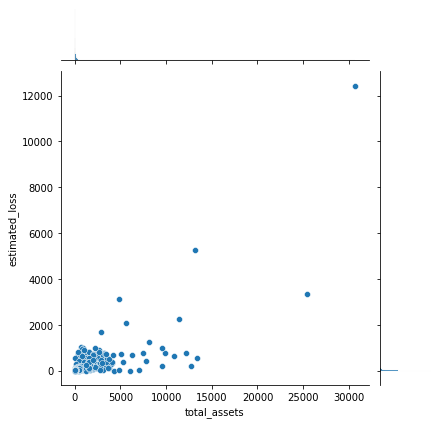

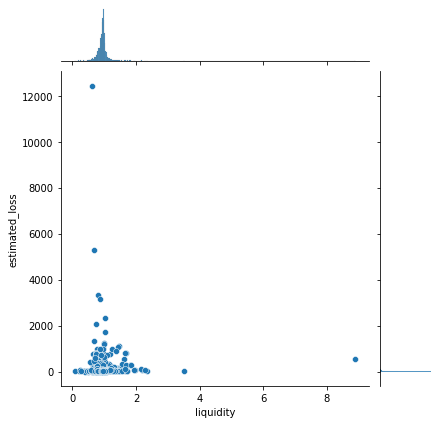

In [37]:
# plot box plots to see outliers
for c in num_cols:
    if c != 'estimated_loss':
        sns.jointplot(x=c, y='estimated_loss', data=data)
    plt.show()

##### From these plots we again see the normal ranges of important variables such as the liquidity, total_assets and total_deposits and we also see their relation with the target variable i.e. estimated_loss. But the most important thing we notice is the prescence of outliers which would impact any kind of learning and so we need to deal with them  

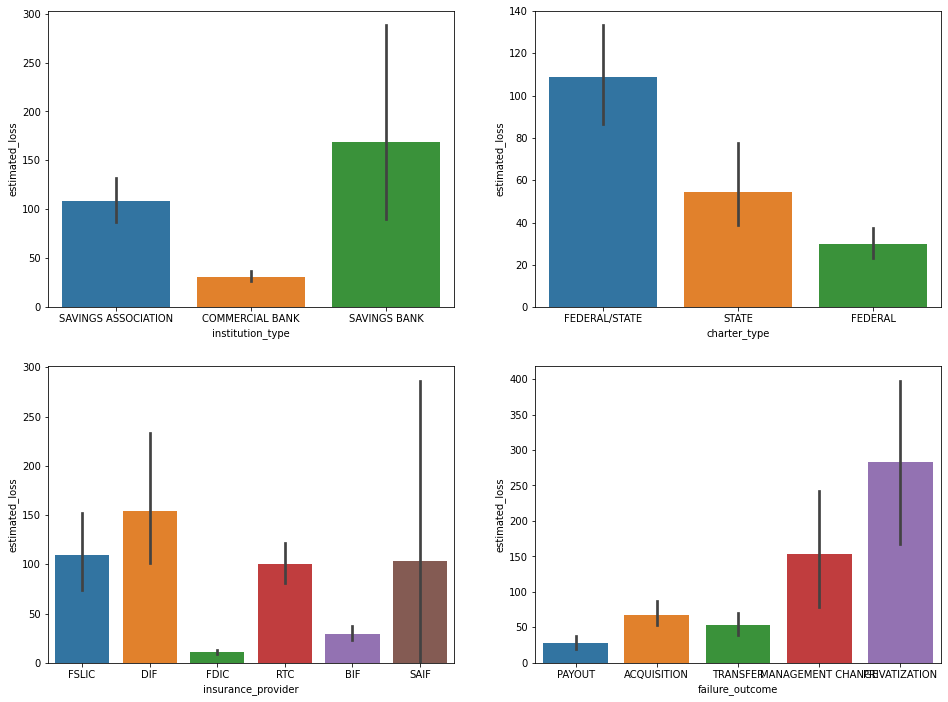

In [38]:
# bar plots for categorical features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
for i, c in enumerate(cat_cols):
    ax = axes.ravel()[i]
    sns.barplot(x=c, y="estimated_loss", ax=ax, data=data)

##### When we take a look at  these plots we get some interesting findings:
1. From plot 1 wee see that Savings Bank have the largest proportion of reported estimated_loss.
2. From plot 2 wee see that Federal/State banks have the largest estimated_loss.
3. From plot 3 wee see that of all the insurance providers, banks with DIF as the insurance provider have the largest amount of estimated_loss.
4. From plot 4 we see that the banks with highest estimated_loss faced Privatization the most in the aftermath.

### Removing Outliers

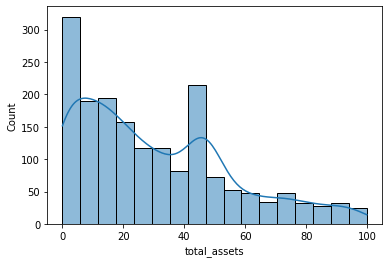

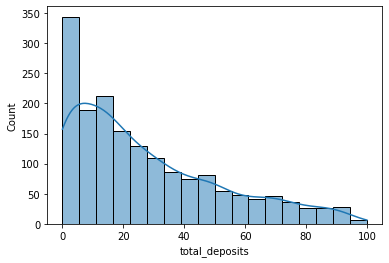

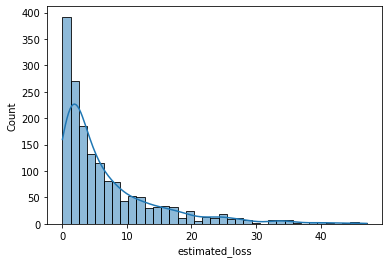

(1686, 25)

In [39]:
cols = ['total_assets', 'total_deposits', 'estimated_loss']
amount = 100
for c in cols:
    if c == 'estimated_loss':
        final_data = final_data[final_data[c] < amount / 2]
    else:
        final_data = final_data[final_data[c] < amount]
    sns.histplot(final_data[c], kde=True)
    plt.show()
final_data.shape

##### The distribution of num_lab_procedures and num_medications is almost normal whereas the others are skewed.

<AxesSubplot:>

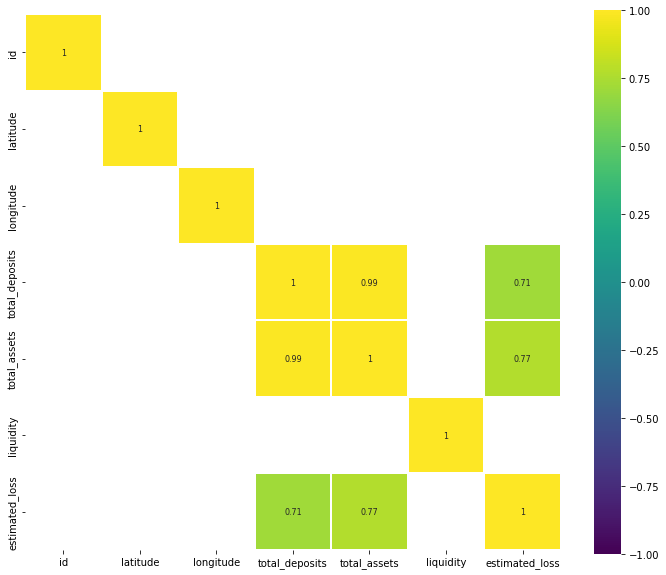

In [40]:
# Correlation heatmap
corr = data.corr() 
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.4) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

##### The correlation matrix shows that total_deposits and total_assets are totally correlated. So we'll remove total_assets before training.

### Normalize Numeric Data

In [41]:
# removing target variable from list of columns to be normalized
num_cols.remove('estimated_loss')

In [42]:
# normalize on numeric data 
scaler = MinMaxScaler()
scaler.fit(final_data[num_cols])
final_data[num_cols] = scaler.transform(final_data[num_cols])

### Train Test Split

In [43]:
y = final_data['estimated_loss']
X = final_data.drop(columns = ['id', 'total_assets', 'estimated_loss'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print('Dimensions of Training Set', X_train.shape)
print('Dimensions of Validation Set', X_test.shape)

Dimensions of Training Set (1348, 22)
Dimensions of Validation Set (338, 22)


### Model Training

In [44]:
# train random forest regression model
randomf = RandomForestRegressor(n_estimators=1000, max_depth=100, min_samples_split=12)
randomf.fit(X_train, y_train)

RandomForestRegressor(max_depth=100, min_samples_split=12, n_estimators=1000)

In [45]:
print('MAE for train set:', mean_absolute_error(y_train, randomf.predict(X_train)))
print('MAE for validation set:', mean_absolute_error(y_test, randomf.predict(X_test)))

MAE for train set: 1.5238600506813975
MAE for validation set: 2.813873130453612




**The management wants to know the most important features for the model.**

> #### Task:
- **Visualize the top 20 features and their feature importance.**


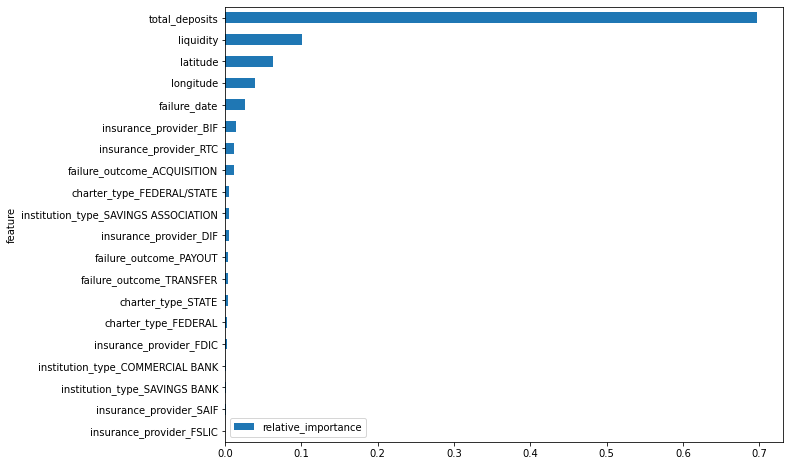

In [46]:
# compute feature importance from random forest classifier
feature_imp=pd.DataFrame()
for feature,imp in zip(X_train.columns,randomf.feature_importances_):
    temp=pd.DataFrame([feature,imp]).T
    feature_imp=feature_imp.append(temp)
feature_imp.columns=['feature','relative_importance']
feature_imp.sort_values(by='relative_importance',inplace=True)
feature_imp.set_index('feature',inplace=True)
feature_imp.iloc[-20:,:].plot(kind='barh',figsize=(10,8))
plt.show()

> #### Task:
- **Submit the predictions on the test dataset using the optimized model** <br/>
    For each record in the test set (`test.csv`), predict the value of the `estimated_loss` variable. Submit a CSV file with a header row and one row per test entry. 

The file (`submissions.csv`) should have exactly 2 columns:
   - **id**
   - **estimated_loss**

In [47]:
# standardize test data
encoded_test_data[num_cols] = scaler.transform(encoded_test_data[num_cols])

In [48]:
# predictions on test data
ids = encoded_test_data['id']
prediction = randomf.predict(encoded_test_data.drop(columns=['id', 'total_assets']))

In [49]:
# get actual values
actual = pd.read_csv('actual_output.csv')

In [50]:
print("MAE on Test Set:", round(mean_absolute_error(actual['estimated_loss'], prediction), 3))

MAE on Test Set: 2.688


In [51]:
#Submission
submission_df = pd.DataFrame({'id': ids, 'estimated_loss': prediction})
submission_df.to_csv('submissions.csv',index=False)